<a href="https://colab.research.google.com/github/faisalrasbihan/gru-momentum-trading/blob/main/gru9_momentum_trading_REGRESSION_F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Preamble

In [42]:
import pandas as pd
import numpy as np
import datetime as dt
from numpy import ones,vstack
from numpy.linalg import lstsq
import missingno as msno
from tqdm import tqdm

# Machine Learning
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, Conv1D, GRU
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K

# Data Visualizations
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from itertools import combinations_with_replacement 
import multiprocessing

# Math & Stats
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, recall_score
from scipy import stats

# Import custom utility funciton 
import _data_processor as dp
import _visualize as viz
import _predict_model as pm
import _trade_simulation as tm

sns.set()

# 1. Import Data

In [43]:
# Read CSV - LQ45 Historical Data
df = pd.read_csv('dataset/LQ45_20210309.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df = df.set_index('Date').sort_index().rename(columns={"Price": "Close"})
df.drop(['LQ45_Vol'],axis=1,inplace=True)

# read IDX30 data
IDX30 = pd.read_csv('dataset/IDX30_20210309.csv').rename(columns={"IDX30_Vol": "Volume"})
IDX30['Date'] = pd.to_datetime(IDX30['Date'], format='%d/%m/%Y')
IDX30 = IDX30.set_index('Date').sort_index().rename(columns={"Price": "IDX30"})

# read IHSG data
IHSG = pd.read_csv('dataset/IHSG_20210309.csv')
IHSG['Date'] = pd.to_datetime(IHSG['Date'], format='%d/%m/%Y')
IHSG = IHSG.set_index('Date').sort_index().rename(columns={"Price": "IHSG"})

IDX30.replace(0, np.nan, inplace=True)
IDX30['Volume'] = IDX30['Volume']/1000000000
IDX30.loc[IDX30.Volume > 13, 'Volume'] = np.nan

IDX30 = IDX30[['IDX30','Volume']]
IHSG = IHSG[['IHSG']]

# read EIDO data
EIDO = pd.read_csv('dataset/EIDO_20210309.csv')
EIDO['Date'] = pd.to_datetime(EIDO['Date'], format='%d/%m/%Y')
EIDO = EIDO.set_index('Date').sort_index().rename(columns={"Price": "EIDO"})

# read SPY data
SPY = pd.read_csv('dataset/SPY_20210309.csv')
SPY['Date'] = pd.to_datetime(SPY['Date'], format='%d/%m/%Y')
SPY = SPY.set_index('Date').sort_index().rename(columns={"Price": "SPY"})

SPY = SPY[['SPY']]#.resample('D').mean().shift(1).fillna(method='ffill')
EIDO = EIDO[['EIDO']]#.resample('D').mean().shift(1).fillna(method='ffill')

In [44]:
jci_value = pd.read_csv('dataset/JCI_value.csv')
jci_value['date'] = pd.to_datetime(jci_value['date'], format='%d/%m/%Y')
jci_value = jci_value.set_index('date').sort_index()

In [45]:
df = df.merge(SPY, how='outer', left_index=True, right_index=True).copy()
df = df.merge(EIDO, how='outer', left_index=True, right_index=True).copy()
df = df.merge(IHSG, how='left', left_index=True, right_index=True).copy()
df = df.merge(IDX30, how='left', left_index=True, right_index=True).copy()
df = df.merge(jci_value[['for_flow','dom_total','tot_buy']], how='left', left_index=True, right_index=True).copy()

# 2. Helper Functions

In [46]:
def sign_accuracy(true,pred):
    true = (true*STD) + MEAN
    pred = (pred*STD) + MEAN
    return K.mean(K.equal(K.sign(true), K.sign(pred)))

In [47]:
def generate_prediction(m, X, y, dates=dt.datetime(2012, 5, 1)):
    pred = m.predict(X)[:,0]
    true = y[:,0]
    train_result = pm.bundle_predicted_actual(true,pred)
    train_result['mse'] = np.abs(train_result['true'] - train_result['pred']).rolling(7).sum()
    train_result['squared_hinge'] = 1 - train_result['true'] * train_result['pred']
    train_result.loc[train_result['squared_hinge'] < 0,'squared_hinge'] = 0
    train_result['squared_hinge'] = train_result['squared_hinge']**2
    train_result['rolling_error'] = train_result['squared_hinge'].rolling(7).mean()
    train_result['date'] = dates
    train_result['date_str'] = train_result['date'].dt.strftime('%Y-%m-%d')
    train_result['date_to_val'] = train_result['date'].map(pd.Series(data=np.arange(len(train_result)), 
                                                                     index=train_result['date'].values).to_dict())
    return pred,true,train_result

In [48]:
def create_model(neurons,output_timesteps,shape1,shape2,loss_function):
    model = tf.keras.Sequential()
    model.add(GRU(neurons, activation='linear', input_shape=(shape1,shape2)))
    model.add(Dense(output_timesteps, activation='tanh'))
    model.compile(optimizer='adam', loss=loss_function, metrics=[sign_accuracy])
    return model

In [49]:
def multi_gru_model(neurons,output_timesteps,shape1,shape2,loss_function):
    model = tf.keras.Sequential()
    model.add(GRU(50, return_sequences=True, activation='linear', input_shape=(shape1,shape2)))
    model.add(Dropout(0.2))
    model.add(GRU(50, activation='linear'))
    model.add(Dropout(0.2))
    model.add(Dense(output_timesteps, activation='tanh'))
    model.compile(optimizer='adam', loss=loss_function, metrics=[sign_accuracy])
    return model

In [50]:
def multi_layer_model(gru_neurons,hidden_neurons,output_timesteps,shape1,shape2,loss_function):
    model = tf.keras.Sequential()
    model.add(GRU(gru_neurons, activation='linear', input_shape=(shape1,shape2)))
    model.add(Dense(hidden_neurons, activation='tanh'))
    model.add(Dense(1, activation='tanh'))
    model.compile(optimizer='adam', loss=loss_function, metrics=[sign_accuracy])
    return model

In [51]:
MEAN_pre_filtered = 0.06968521192214656
STD_pre_filtered = 2.3073312870270306

def target_inverse_transform(x, mean=MEAN_pre_filtered, std=STD_pre_filtered):
    return (x*STD) + MEAN

def target_transform(x, mean=MEAN_pre_filtered, std=STD_pre_filtered):
    return (x - MEAN)/STD

In [52]:
def train_test_date_split(df_orig, range1='2020-01-01', range2='2019-01-01', range3='2020-01-01', range4='2021-02-01'):
    df = df_orig.copy()
    df_train = df[(df.index < range1)].copy()
    df_test = df[(df.index >= range2) & (df.index < range3)].copy()
    df_test2 = df[(df.index >= range3) & (df.index < range4)].copy()
    return df_train, df_test, df_test2

In [53]:
def plot_all(df, cols):
    fig, ax = plt.subplots(len(cols), 2, figsize=(18,len(cols)*4), gridspec_kw={'width_ratios': [1, 3]})
    colors = sns.color_palette()
    colors += colors
    for i, col in enumerate(cols):
        sns.histplot(df[col], ax=ax[i,0], color=colors[i])
        ax[i,1].plot(df.index, df[col], color=colors[i])
        ax[i,1].set_title(col)
        ax[i,0].grid()
#         ax[i,0].set_ylim(0,ylim)
    plt.tight_layout()

In [54]:
def hampel(vals_orig, k=7, t0=3):
    #Make copy so original not edited
    vals = vals_orig.copy()
    
    #Hampel Filter
    L = 1.4826
    rolling_median = vals.rolling(window=k, center=True).median()
    MAD = lambda x: np.median(np.abs(x - np.median(x)))
    rolling_MAD = vals.rolling(window=k, center=True).apply(MAD)
    threshold = t0 * L * rolling_MAD
    difference = np.abs(vals - rolling_median)
    
    outlier_idx = difference > threshold
    vals[outlier_idx] = rolling_median[outlier_idx] 
    return outlier_idx, vals

# 3. Feature Engineering

In [55]:
# Filter volume
outlier_idx, dom_filtered = hampel(df.dom_total,k=20,t0=9)
dom_outlier = df.dom_total.copy()
dom_outlier[~outlier_idx] = np.nan
df['dom_filtered'] = dom_filtered

outlier_idx, for_filtered = hampel(df.for_flow,k=20,t0=9)
for_outlier = df.for_flow.copy()
for_outlier[~outlier_idx] = np.nan
df['for_flow_filtered'] = for_filtered

outlier_idx, total_buy_filtered = hampel(df.tot_buy,k=20,t0=9)
tot_outlier = df.tot_buy.copy()
tot_outlier[~outlier_idx] = np.nan
df['total_buy_filtered'] = total_buy_filtered

In [56]:
# Resample Date to fill missing date
df = df.resample('D').mean()

# Interpolate Close and Volume Values
df.interpolate(inplace=True)

# Remove saturday and sunday data
df['day_of_week'] = df.index.dayofweek + 1
df = df[df['day_of_week'] < 6].copy()
df.drop(columns=['day_of_week'],inplace=True)

df = df[df.index >= '2012-04-24'].copy()

## 3.3 Create Engineered Features

In [57]:
MA_PERIOD = 5
FUTURE_DAYS = 3

df['momentum'] = dp.momentum_transformation(df, 'Close', ma_span=MA_PERIOD, normalized=False)
# df['price_volatility'] = df['1day_price_change'].rolling(10).std()
df['linear_series'] = (df.reset_index().index + 1000) / 1000
df['target'] = df['Close'].pct_change(periods=FUTURE_DAYS).shift(-(FUTURE_DAYS)) * 100

df['EIDO'] = 100*df['EIDO']/df['EIDO'][0]
df['SPY'] = 100*df['SPY']/df['SPY'][0]
df['EIDO_SPY_diff'] = df['EIDO'] - df['SPY']
df['EIDO_SPY_ma'] = df['EIDO_SPY_diff'].rolling(7).mean()

df['IDX30'] = 100*df['IDX30']/df['IDX30'][0]
df['IHSG'] = 100*df['IHSG']/df['IHSG'][0]
df['IDX30_IHSG_diff'] = df['IDX30'] - df['IHSG']
df['IDX30_IHSG_ma'] = df['IDX30_IHSG_diff'].rolling(7).mean()

df['dom_filtered'] = df['dom_filtered'] / (10**6)
df['for_flow_filtered'] = df['for_flow_filtered'] / (10**6)
df['total_buy_filtered'] = df['total_buy_filtered']/(10**6)

df['dom_val_ma'] = df['dom_filtered'].rolling(7).mean()
df['for_flow_ma'] = df['for_flow_filtered'].rolling(7).mean()
df['total_val_grad'] = df['total_buy_filtered'].rolling(3).mean() - df['total_buy_filtered'].rolling(11).mean().shift(3)

## 3.1 Remove outliers on target

In [58]:
# Remove outliers
df = df[(df['target'] < 3*STD_pre_filtered) & (df['target'] > -3*STD_pre_filtered)]

# Determine mean and standard deviation
MEAN = np.mean(df['target'].values)
STD = np.std(df['target'].values)
print('Mean: ', MEAN)
print('STD: ', STD)

# Plot result
fig = px.histogram(df, x="target",
                   marginal="box", # or violin, rug
                   hover_data=df.columns)
fig.show()


Mean:  0.10263738808988873
STD:  1.907956821190298


In [59]:
# # Determine 33% and 66% quartile from target
# quantile_33 = np.quantile(df['target'], 0.33)
# quantile_66 = np.quantile(df['target'], 0.66)

# # Set target at 0 for 33-66% quantile
# mask = (df.target > quantile_33) & (df.target < quantile_66)
# df.loc[mask, 'target'] = 0

# # Plot result
# fig = px.histogram(df, x="target",
#                    marginal="box", # or violin, rug
#                    hover_data=df.columns)
# fig.show()

# 4. Train Model

In [85]:
slow_and_fast = [(6,6),(7,5),(8,4),(9,3),(9,7),(10,6),(8,6),(9,5),(10,4),(11,3)]
combi = list(combinations_with_replacement(slow_and_fast,3))
highacc_combi = list(combi[i] for i in [4, 14, 21, 28])
highacc_combi

[((6, 6), (6, 6), (9, 7)),
 ((6, 6), (7, 5), (10, 6)),
 ((6, 6), (8, 4), (9, 7)),
 ((6, 6), (9, 3), (9, 7))]

In [86]:
target_variables = 'target'
input_variables = ['momentum','IDX30_IHSG_grad','EIDO_SPY_grad','total_val_grad','dom_val_ma','for_flow_ma']
neurons = 90
multi_neurons = (20,5)
loss = 'squared_hinge'
input_timesteps = 20
output_timesteps = 1
epochs = 80
validation_split = 0.2
span = 4
d = highacc_combi[1]

In [87]:
# Final Variables
df2 = df.copy()
df2['momentum'] = dp.momentum_transformation(df2, 'Close', ma_span=span, normalized=False)
df2['EIDO_SPY_grad'] = df2['EIDO_SPY_diff'].rolling(d[0][1]).mean() - df2['EIDO_SPY_diff'].rolling(d[0][0]).mean().shift(d[0][1])
df2['IDX30_IHSG_grad'] = df2['IDX30_IHSG_diff'].rolling(d[1][1]).mean() - df2['IDX30_IHSG_diff'].rolling(d[1][0]).mean().shift(d[1][1])
df2['Volume_grad'] = df2['Volume'].rolling(d[2][1]).mean() - df2['Volume'].rolling(d[2][0]).mean().shift(d[2][1])

df2['target'] = df2['target'].apply(target_transform, mean=MEAN, std=STD) # Standardize target with predetermined constants

# Train test split
df2 = df2.dropna()

# Final Sanity Check
df2[(df2.index > '2020-11-09')][input_variables + [target_variables]]

,momentum,IDX30_IHSG_grad,EIDO_SPY_grad,total_val_grad,dom_val_ma,for_flow_ma,target
Date,,,,,,,
2020-11-10,25.0850,1.597008,-2.882731,3.667802,14.928623,0.458449,0.142151
2020-11-11,25.1700,2.720250,-6.302816,5.519832,16.853821,0.817652,-0.445685
2020-11-12,3.8850,3.346266,-7.824455,5.160973,17.506280,0.894226,0.861186
2020-11-13,-2.2675,3.563341,-7.583980,2.188416,17.629074,0.859133,1.061292
2020-11-16,1.6050,3.637999,-6.788395,-0.638807,17.588039,0.704874,0.767095
...,...,...,...,...,...,...,...
2021-02-25,-0.8875,-0.325635,1.484702,1.546248,21.119597,0.167836,0.778161
2021-02-26,-7.0550,-0.355907,2.701141,4.654130,21.743407,0.168898,1.248256
2021-03-01,13.7875,0.008931,2.905305,3.835739,21.814481,0.173242,-1.096382


In [102]:
df_train = df2[(df2.index < '2019-01-01')].copy()
df_test = df2[(df2.index >= '2019-01-01') & (df2.index <= '2020-02-01')].copy()
df_test2 = df2[(df2.index >= '2020-01-01') & (df2.index <= '2021-02-01')].copy()
df_test3 = df2[(df2.index >= '2020-01-01') & (df2.index <= '2021-02-01')].copy()

# Unroll data
dates = df_train[(input_timesteps+output_timesteps-1):].index

# Separate train and test data
X_train, y_train = dp.generate_batch(df_train, input_timesteps, output_timesteps, input_variables, target_variables)
######### DELETE LATER #########
lower_thresh = np.quantile(y_train, 0.4)
upper_thresh = np.quantile(y_train, 0.6)
mask = (y_train < lower_thresh) | (y_train > upper_thresh)
X_train = X_train[mask[:,0]]
y_train = y_train[mask[:,0]]
######### DELETE LATER #########
X_test, y_test = dp.generate_batch(df_test, input_timesteps, output_timesteps, input_variables, target_variables)
X_test2, y_test2 = dp.generate_batch(df_test2, input_timesteps, output_timesteps,  input_variables, target_variables)
X_test3, y_test3 = dp.generate_batch(df_test3, input_timesteps, output_timesteps,  input_variables, target_variables)

# Build LSTM Model using Tensorflow
model = create_model(neurons, output_timesteps, X_train.shape[1], X_train.shape[2], loss)
# model = multi_layer_model(multi_neurons[0],multi_neurons[1],output_timesteps,X_train.shape[1], X_train.shape[2],loss)
# model = multi_layer_model(multi_neurons[0],multi_neurons[1],output_timesteps,X_train.shape[1], X_train.shape[2],loss)

model_name = 'gru7_oneoff_n{neurons}_{feature_count}var_span{span}_X1.hdf5'.format(
                                                                                neurons=neurons,
                                                                                span=span,
                                                                                feature_count=len(input_variables))
model_path = 'temp_model/{}'.format(model_name)
mcp_save = ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss', mode='min',verbose=2)

history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=len(X_train),
    validation_split=validation_split,
    verbose = 2, 
    shuffle=True,
    callbacks=[mcp_save]
)

new_model = tf.keras.models.load_model(model_path, compile=False)

Epoch 1/80
1/1 - 2s - loss: 1.3011 - sign_accuracy: 0.5467 - val_loss: 1.1967 - val_sign_accuracy: 0.5535

Epoch 00001: val_loss improved from inf to 1.19668, saving model to temp_model/gru7_oneoff_n90_6var_span4_X1.hdf5
Epoch 2/80
1/1 - 0s - loss: 1.1828 - sign_accuracy: 0.5606 - val_loss: 1.1933 - val_sign_accuracy: 0.5129

Epoch 00002: val_loss improved from 1.19668 to 1.19333, saving model to temp_model/gru7_oneoff_n90_6var_span4_X1.hdf5
Epoch 3/80
1/1 - 0s - loss: 1.1326 - sign_accuracy: 0.5634 - val_loss: 1.1065 - val_sign_accuracy: 0.5424

Epoch 00003: val_loss improved from 1.19333 to 1.10655, saving model to temp_model/gru7_oneoff_n90_6var_span4_X1.hdf5
Epoch 4/80
1/1 - 0s - loss: 1.0973 - sign_accuracy: 0.5615 - val_loss: 1.0278 - val_sign_accuracy: 0.5683

Epoch 00004: val_loss improved from 1.10655 to 1.02783, saving model to temp_model/gru7_oneoff_n90_6var_span4_X1.hdf5
Epoch 5/80
1/1 - 0s - loss: 1.0482 - sign_accuracy: 0.5513 - val_loss: 1.0032 - val_sign_accuracy: 0.542

In [103]:
# plot training history
hist = pd.DataFrame.from_dict(history.history)
# fig = go.Figure()

fig = make_subplots(rows=1, 
                    cols=2,
                    subplot_titles=("Train and Validation Loss per epoch", "Train and Validation Accuracy per epoch"))

# Plot Train and Validation Loss per epoch
fig.add_trace(go.Scatter(y=hist['loss'],
                         line=dict(color='blue')
                         ,name='train_loss'),
    row=1, col=1)
fig.add_trace(go.Scatter(y=hist['val_loss'],
                         line=dict(color='firebrick'),
                         name='val_loss'),
    row=1, col=1)

# Plot Train and Validation Accuracy per epoch
fig.add_trace(go.Scatter(y=hist['sign_accuracy'],
                         line=dict(color='blue'),
                         name='train'),
    row=1, col=2)
fig.add_trace(go.Scatter(y=hist['val_sign_accuracy'],
                         line=dict(color='firebrick'),
                         name='val'),
    row=1, col=2)

# Set x and y axes title
fig.update_xaxes(title_text="Epoch", row=1, col=1)
fig.update_xaxes(title_text="Epoch", row=1, col=2)

fig.update_yaxes(title_text="Loss", row=1, col=1)
fig.update_yaxes(title_text="Accuracy", row=1, col=2)


fig.show()

# 5. Evaluate Model

In [104]:
# Generate result from model
_,_,train_result = generate_prediction(new_model,X_train,y_train)
_,_,test_result = generate_prediction(new_model,X_test,y_test,df_test.index[(input_timesteps+output_timesteps-1):])
_,_,test_result2 = generate_prediction(new_model,X_test2,y_test2,df_test2.index[(input_timesteps+output_timesteps-1):])
_,_,test_result3 = generate_prediction(new_model,X_test3,y_test3,df_test3.index[(input_timesteps+output_timesteps-1):])

## 5.1 Train Result Evaluation

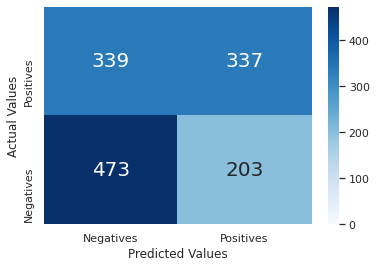

In [109]:
conf_matrix = confusion_matrix(train_result['true_bin'], train_result['pred_bin'])[::-1]
viz.display_confusion_matrix(conf_matrix, reverse_ylabel=True)

In [110]:
print(classification_report(train_result['true_bin'],train_result['pred_bin'], target_names=['Negatives','Positives']))

              precision    recall  f1-score   support

   Negatives       0.58      0.70      0.64       676
   Positives       0.62      0.50      0.55       676

    accuracy                           0.60      1352
   macro avg       0.60      0.60      0.60      1352
weighted avg       0.60      0.60      0.60      1352



In [111]:
fig = px.scatter(train_result, x="pred", y="true", color="squared_hinge", 
                 trendline="ols",
                 title="Train Result",
                 width=800, height=800, hover_data=["date_str"])
fig.show()

## 5.2 Test Result Evaluation

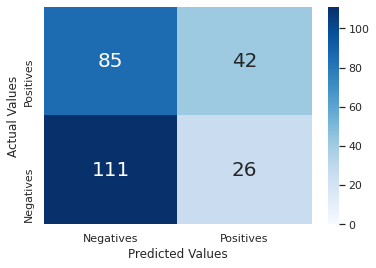

In [112]:
conf_matrix2 = confusion_matrix(test_result['true_bin'],test_result['pred_bin'])[::-1]
viz.display_confusion_matrix(conf_matrix2, reverse_ylabel=True)

In [113]:
print(classification_report(test_result['pred_bin'], test_result['true_bin'], target_names=['Negatives','Positives']))

              precision    recall  f1-score   support

   Negatives       0.81      0.57      0.67       196
   Positives       0.33      0.62      0.43        68

    accuracy                           0.58       264
   macro avg       0.57      0.59      0.55       264
weighted avg       0.69      0.58      0.61       264



Text(30.5, 0.5, 'Actual Values')

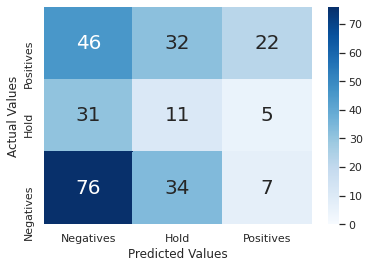

In [114]:
test_pred_ter = np.where(test_result['pred'] < lower_thresh,-1,np.where(test_result['pred'] > upper_thresh,1,0))
test_true_ter = np.where(test_result['true'] < lower_thresh,-1,np.where(test_result['true'] > upper_thresh,1,0))
conf_matrix = confusion_matrix(test_true_ter,test_pred_ter)[::-1]
labels = ['Negatives','Hold','Positives']
sns.heatmap(conf_matrix, 
                annot=True, 
                cmap="Blues",
                fmt="d",vmin=0, 
                annot_kws={"size": 20}, 
                xticklabels = labels, 
                yticklabels= labels[::-1])
plt.xlabel('Predicted Values', fontsize = 12) # x-axis label with fontsize 15
plt.ylabel('Actual Values', fontsize = 12)

In [115]:
fig = px.scatter(test_result, x="pred", y="true", color="squared_hinge", 
                 trendline="ols",
                 title="Test Result",
                 width=800, height=800, hover_data=["date_str"])
fig.show()

#  6. Run Trading Simulation

In [116]:
def plot_returns(df):
    fig, ax = plt.subplots(3, 1, sharex=True, figsize=[24, 12])
    
    # Add patch as legend
    red_patch = mpl.patches.Patch(color='#bb3f3f', label='Sell')
    green_patch = mpl.patches.Patch(color='#008000', label='Buy')
    
    # Closing price chart
    close = 100*df['Close']/df['Close'][0]
    sns.lineplot(data=close, ax=ax[0])
    ax[0].set_ylabel('Closing Price')
    buys = df.loc[df.position == 'Buy'] # mark buy transactions
    sells = df.loc[df.position == 'Sell'] # mark sell transactions
    
    # Add dashed line on last closing price
    last_closing_price = close[-1]
    ax[0].axhline(last_closing_price, ls='--',linewidth=1, color='m')
    ax[0].plot(buys.index, close.loc[buys.index], '.', markersize=8, color='g', label='buy')
    ax[0].plot(sells.index, close.loc[sells.index], '.', markersize=8, color='r', label='sell')
    ax[0].annotate((last_closing_price).round(2),xy=(1,last_closing_price),xycoords=('axes fraction','data'),ha='left',va='center',color='black')
    ax[0].grid(True)
    ax[0].legend(handles=[red_patch, green_patch])

    # Price change chart
    sns.lineplot(data=df[['target','pred']], ax=ax[1])
    ax[1].set_ylabel('target'.format(3))
    ax[1].grid(True)

    # Portfolio value
    port_value = df['value'] / df['value'][0]
    sns.lineplot(data=port_value, ax=ax[2])
    ax[2].set_ylabel('Portfolio Value')
    last_value = port_value[-1]
    ax[2].axhline(last_value, ls='--',linewidth=1, color='m')
    ax[2].annotate((last_value).round(2),xy=(1,last_value),xycoords=('axes fraction','data'),ha='left',va='center',color='black')
    ax[2].grid(True)

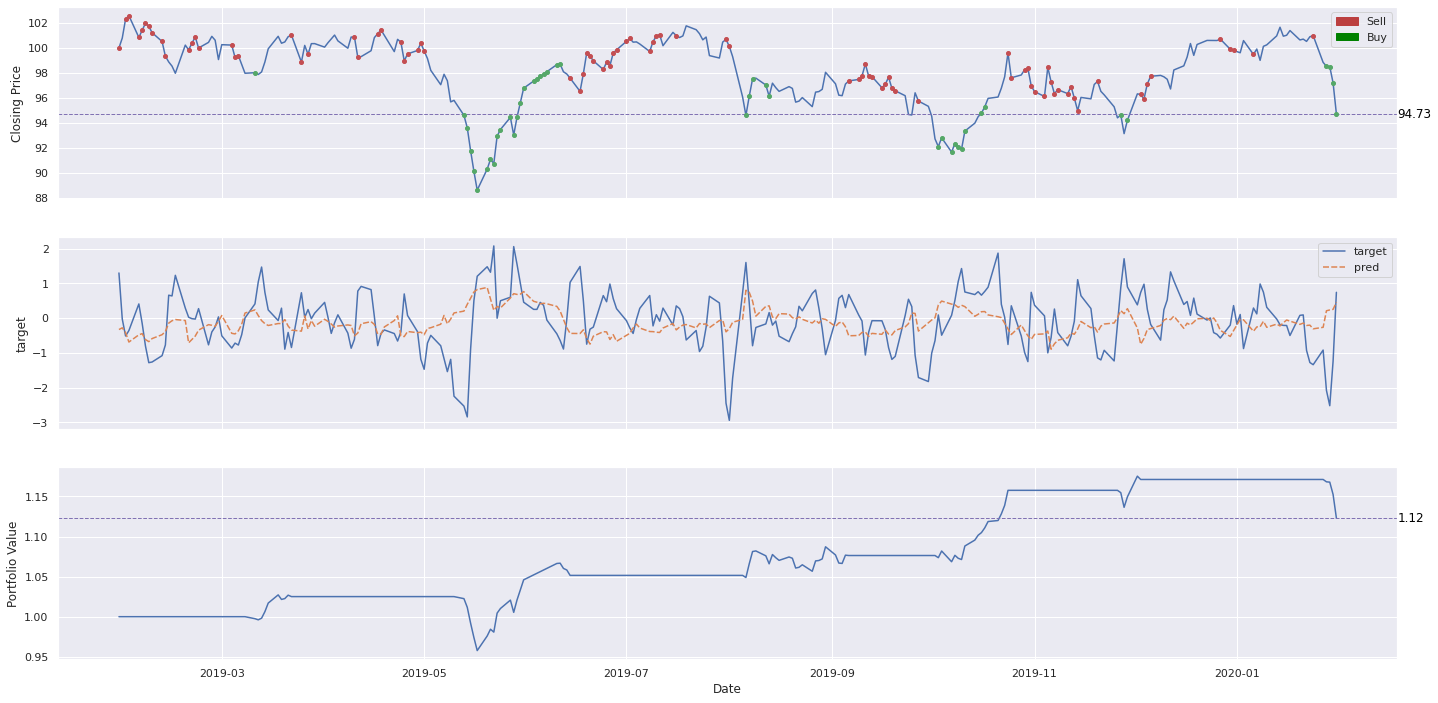

In [123]:
test_date = df_test[(input_timesteps+output_timesteps-1):].index
res = pd.DataFrame(test_date)
res['pred'] = test_result['pred']
res = res.set_index(['Date'])
res = df_test.merge(res, how='inner', left_index=True, right_index=True).copy()

test_returns = tm.simulate_position(res,0.15,-0.3,buy_fee=0.0025,sell_fee=0.003)#dp.generate_returns(res)
plot_returns(test_returns)

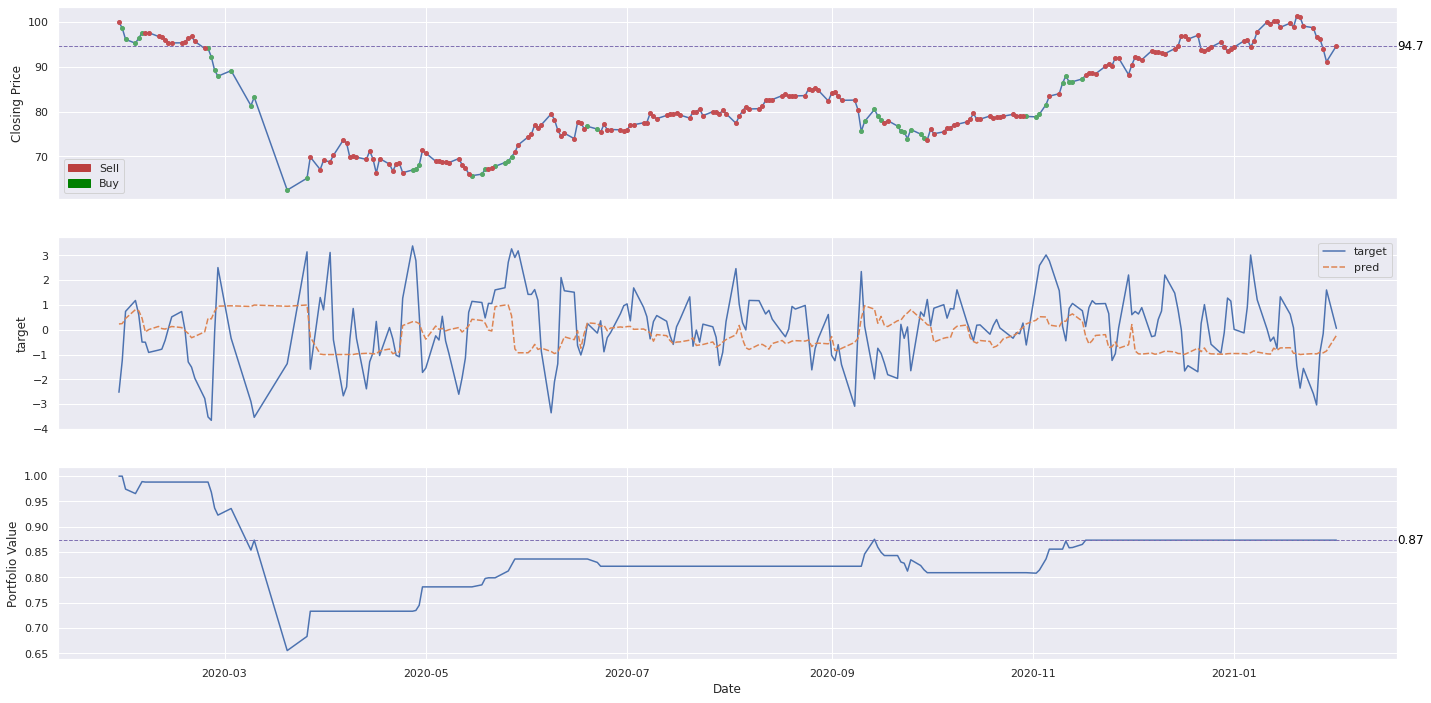

In [122]:
test_date2 = df_test2[(input_timesteps+output_timesteps-1):].index
res = pd.DataFrame(test_date2)
res['pred'] = test_result2['pred']
res = res.set_index(['Date'])

res = df_test2.merge(res, how='inner', left_index=True, right_index=True).copy()

test_returns2 = tm.simulate_position(res,lower_thresh,upper_thresh)#dp.generate_returns(res)
plot_returns(test_returns2)